<a href="https://colab.research.google.com/github/duckbillLvr/software-lecture/blob/main/lecture6_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install finterstellar

     |████████████████████████████████| 109 kB 6.8 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [ ]:
import finterstellar as fs

In [ ]:
# backting term and data setting
terms = fs.set_terms(trade_start='2011Q1', trade_end='2021Q1')
data = {}
for t in terms:
  data[t] = fs.fn_consolidated(otp='16487125231099712210', term=t)

2010Q4...OK
2011Q1...OK
2011Q2...OK
2011Q3...OK
2011Q4...OK
2012Q1...OK
2012Q2...OK
2012Q3...OK
2012Q4...OK
2013Q1...OK
2013Q2...OK
2013Q3...OK
2013Q4...OK
2014Q1...OK
2014Q2...OK
2014Q3...OK
2014Q4...OK
2015Q1...OK
2015Q2...OK
2015Q3...OK
2015Q4...OK
2016Q1...OK
2016Q2...OK
2016Q3...OK
2016Q4...OK
2017Q1...OK
2017Q2...OK
2017Q3...OK
2017Q4...OK
2018Q1...OK
2018Q2...OK
2018Q3...OK
2018Q4...OK
2019Q1...OK
2019Q2...OK
2019Q3...OK
2019Q4...OK
2020Q1...OK
2020Q2...OK
2020Q3...OK
2020Q4...OK


### 1. 그린블라트의 마법공식
NCAV(그레이엄의 청산가치)를 보완한 공식

- 그린블라트의 마법공식 : 좋은 회사의 주식을 싼 가격에 사기
> - 좋은 회사 : 높은 자본수익률(ROC = EBIT/Return of Capital)보유  
> - 싼 가격 : 높은 이익수익률(PER의 역수) 보유

In [ ]:
# 코카콜라의 재무제표 데이터
df = fs.fn_single(otp='16487125231099712210', symbol = 'KO', window='T')

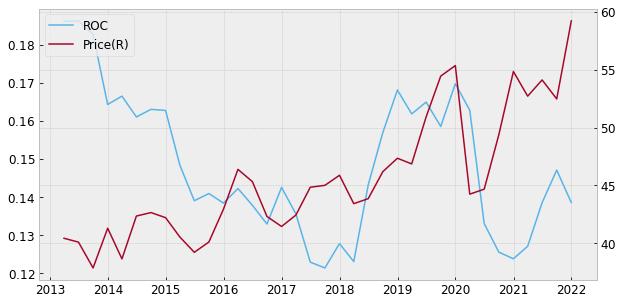

In [ ]:
df['ROC'] = df['EBIT'] / (df['Total Assets'] - df['Current Liabilities'])
fs.draw_chart(df, left='ROC', right='Price')

CAGR: 4.16%
Accumulated return: 50.36%
Investment period: 10.0yrs
Sharpe ratio: 0.17
MDD: -54.68%


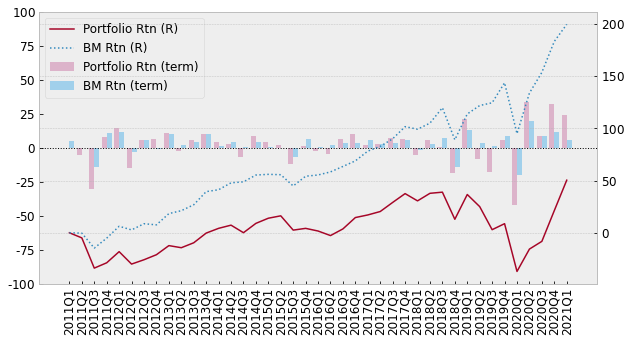

In [ ]:
# Magic Formular backtesting
# PER, ROC 결합
s1, s2, s, signal = {}, {}, {}, {}
for t in terms:
  prev_t = fs.quarters_before(terms, t, 4)
  data[t]['PER'] = data[t]['Price_M3'] / data[t]['EPS'] # PER의 역수 = 이익 수익률(Earnings Yield)
  data[t]['Avg Assets'] = (data[t]['Total Assets'] + data[prev_t]['Total Assets']) / 2 # 현재 평균 자산
  data[t]['Avg Current Liabilities'] = (data[t]['Current Liabilities'] + data[prev_t]['Current Liabilities']) / 2 # 현재 평균 부채
  data[t]['ROC'] = data[t]['EBIT'] / ( data[t]['Avg Assets'] - data[t]['Avg Current Liabilities']) # EBIT / 투입자본(=자산-부채)
  s1[t] = fs.fn_score(data[t], by='PER', method='relative', floor=1, cap=10, asc=True) # PER 하위권 = 높은 이익 수익률
  s2[t] = fs.fn_score(data[t], by='ROC', method='relative', floor=0, asc=False) # ROC 상위권 = 높은 자본수익률
  s[t] = fs.combine_score(s1[t], s2[t], n=30)
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001, rf_rate=.01)
fs.draw_return(df)

CAGR: 22.38%
Accumulated return: 654.60%
Investment period: 10.0yrs
Sharpe ratio: 1.64
MDD: -44.44%


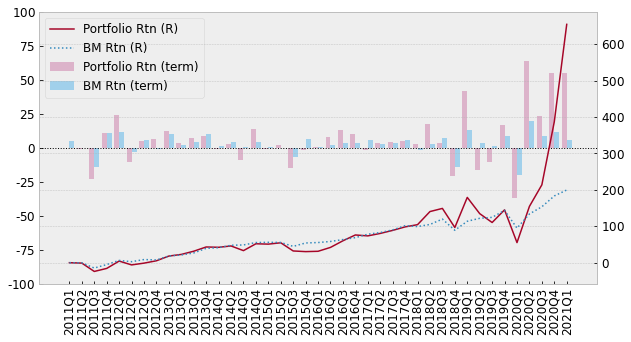

In [ ]:
# 강환국 developed 마법공식
# PBR, GP/A 결합
s1, s2, s, signal = {}, {}, {}, {}
for t in terms:
  prev_t = fs.quarters_before(terms, t, 4)
  #PBR
  data[t]['PBR'] = data[t]['Price_M3'] / (data[t]['Shareholders Equity'] / data[t]['Shares'])
  #GP/A
  data[t]['Avg Assets'] = (data[t]['Total Assets'] + data[prev_t]['Total Assets']) / 2
  data[t]['GP/A'] = data[t]['Gross Profit'] / data[t]['Avg Assets'] # GP/A = 매출 총이익 / 총 자산

  s1[t] = fs.fn_score(data[t], by='PBR', method='relative', floor=.1, cap=2, asc=True) # PBR 하위권
  s2[t] = fs.fn_score(data[t], by='GP/A', method='relative', floor=0, asc=False) # GP/A 상위권
  s[t] = fs.combine_score(s1[t], s2[t], n=30)
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001, rf_rate=.01)
fs.draw_return(df)

### 2. 피오트로스키의 F Score

F score는 총 9가지 지표를 결합하여 만든 지표이다.
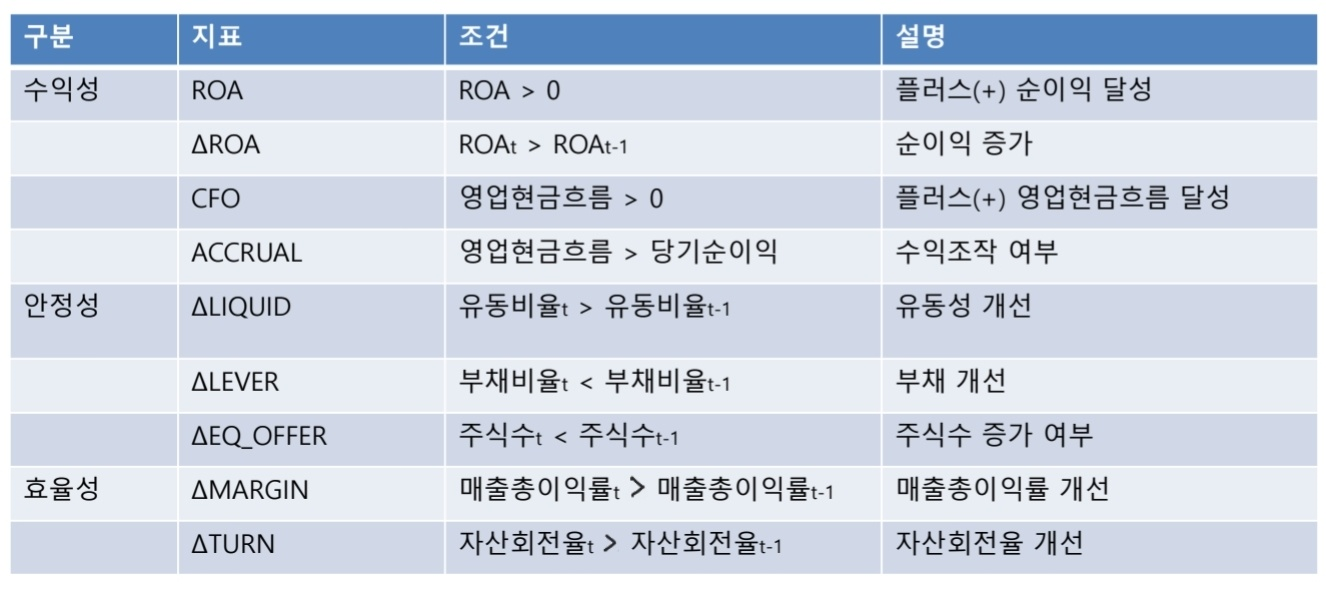

In [ ]:
# 페이스북 F score
df = fs.fn_single(otp='16487125231099712210', symbol='FB', window='T')

In [ ]:
# factor 계산
df['Avg Assets'] = (df['Total Assets'] + df['Total Assets'].shift(4)) / 2
df['ROA'] = df['Net Income'] / df['Avg Assets']
df['Current Ratio'] = df['Current Assets'] / df['Current Liabilities']
df['Debt/Asset'] = df['Long Term Debt'] / df['Total Assets']
df['Gross Margin'] = df['Gross Profit'] / df['Revenue']
df['Asset Turnover'] = df['Revenue'] / df['Avg Assets']

In [ ]:
# F score 초기화
df['F_ROA'] = 0 # 순이익 흑자 달성
df['F_ROA_dt'] = 0 # 순이익 증가
df['F_CFO']= 0 # 영업현금흐름 흑자 달성
df['F_Accrual'] = 0 # 수익조작 여부
df['F_Liquid'] = 0 # 유동성 개선
df['F_Lever']= 0 # 부채 개선
df['F_Shares'] = 0 # 주식수 증가 여부
df['F_Margin'] = 0 # 매출총이익률 개선
df['F_Turn'] = 0 # 자산회전율 개선

df['F_Score'] = 0 # 총점

In [ ]:
df.loc[df['ROA'] > 0, 'F_ROA'] = 1
df.loc[df['ROA'] > df['ROA'].shift(4), 'F_ROA_dt'] = 1
df.loc[df['Operating Cash Flow'] > 0, 'F_CFO'] = 1
df.loc[df['Operating Cash Flow'] - df['Net Income'] > 0, 'F_Accrual'] = 1
df.loc[df['Current Ratio'] - df['Current Ratio'].shift(4) > 0, 'F_Liquid'] = 1
df.loc[df['Debt/Asset'] - df['Debt/Asset'].shift(4) < 0,  'F_Lever'] = 1
df.loc[df['Shares'] - df['Shares'].shift(4) < 0, 'F_Shares'] = 1
df.loc[df['Gross Margin'] - df['Gross Margin'].shift(4) > 0, 'F_Margin'] = 1
df.loc[df['Asset Turnover'] - df['Asset Turnover'].shift(4) > 0, 'F_Turn'] = 1

df['F_Score'] = df['F_ROA'] + df['F_ROA_dt'] + df['F_CFO'] + df['F_Accrual'] + df['F_Liquid'] + df['F_Lever'] + df['F_Shares'] + df['F_Margin'] + df['F_Turn']

In [ ]:
df[['F_Score', 'F_ROA', 'F_ROA_dt', 'F_CFO', 'F_Accrual', 'F_Liquid', 'F_Lever', 'F_Shares', 'F_Margin', 'F_Turn']].tail()

,F_Score,F_ROA,F_ROA_dt,F_CFO,F_Accrual,F_Liquid,F_Lever,F_Shares,F_Margin,F_Turn
2020-12-31,7,1,1,1,1,1,1,1,0,0
2021-03-31,8,1,1,1,1,1,1,1,0,1
2021-06-30,7,1,1,1,1,0,1,1,0,1
2021-09-30,6,1,1,1,1,0,0,1,0,1
2021-12-31,7,1,1,1,1,0,0,1,1,1


In [ ]:
# 피오트로스키의 F Score Backtesting
terms = fs.set_terms(trade_start='2011Q1', trade_end='2021Q1')
data = {}
for t in terms:
  data[t] = fs.fn_consolidated(otp='16487125231099712210', term=t, vol=0)

2010Q4...OK
2011Q1...OK
2011Q2...OK
2011Q3...OK
2011Q4...OK
2012Q1...OK
2012Q2...OK
2012Q3...OK
2012Q4...OK
2013Q1...OK
2013Q2...OK
2013Q3...OK
2013Q4...OK
2014Q1...OK
2014Q2...OK
2014Q3...OK
2014Q4...OK
2015Q1...OK
2015Q2...OK
2015Q3...OK
2015Q4...OK
2016Q1...OK
2016Q2...OK
2016Q3...OK
2016Q4...OK
2017Q1...OK
2017Q2...OK
2017Q3...OK
2017Q4...OK
2018Q1...OK
2018Q2...OK
2018Q3...OK
2018Q4...OK
2019Q1...OK
2019Q2...OK
2019Q3...OK
2019Q4...OK
2020Q1...OK
2020Q2...OK
2020Q3...OK
2020Q4...OK


- F score 백 테스팅
> - 추가 팩터 생성
> - F score 지표 초기화
> - F score 지표 계산
> - F score 총점 계산

In [ ]:
for t in terms:
  prev_t = fs.quarters_before(terms, t, 4)
  # factor 계산
  data[t]['Market Cap'] = data[t]['Price_M3'] * data[t]['Shares']
  data[t]['PBR'] = data[t]['Price_M3'] / (data[t]['Shareholders Equity'] / data[t]['Shares'])
  data[t]['Avg Assets'] = (data[t]['Total Assets'] + data[prev_t]['Total Assets']) / 2
  data[t]['ROA'] = data[t]['Net Income'] / data[t]['Avg Assets']
  data[t]['Current Ratio'] = data[t]['Current Assets'] / data[t]['Current Liabilities']
  data[t]['Debt/Asset'] = data[t]['Long Term Debt'] / data[t]['Total Assets']
  data[t]['Gross Margin'] = data[t]['Gross Profit'] / data[t]['Revenue']
  data[t]['Asset Turnover'] = data[t]['Revenue'] / data[t]['Avg Assets']

  # F score 초기화
  data[t]['F_ROA'] = 0 # 순이익 흑자 달성
  data[t]['F_ROA_dt'] = 0 # 순이익 증가
  data[t]['F_CFO']= 0 # 영업현금흐름 흑자 달성
  data[t]['F_Accrual'] = 0 # 수익조작 여부
  data[t]['F_Liquid'] = 0 # 유동성 개선
  data[t]['F_Lever']= 0 # 부채 개선
  data[t]['F_Shares'] = 0 # 주식수 증가 여부
  data[t]['F_Margin'] = 0 # 매출총이익률 개선
  data[t]['F_Turn'] = 0 # 자산회전율 개선

  data[t]['F_Score'] = 0 # 총점

  # F score 지표 계산
  data[t].loc[data[t]['ROA'] > 0, 'F_ROA'] = 1
  data[t].loc[data[t]['ROA'] > data[t]['ROA'].shift(4), 'F_ROA_dt'] = 1
  data[t].loc[data[t]['Operating Cash Flow'] > 0, 'F_CFO'] = 1
  data[t].loc[data[t]['Operating Cash Flow'] - data[t]['Net Income'] > 0, 'F_Accrual'] = 1
  data[t].loc[data[t]['Current Ratio'] - data[t]['Current Ratio'].shift(4) > 0, 'F_Liquid'] = 1
  data[t].loc[data[t]['Debt/Asset'] - data[t]['Debt/Asset'].shift(4) < 0,  'F_Lever'] = 1
  data[t].loc[data[t]['Shares'] - data[t]['Shares'].shift(4) < 0, 'F_Shares'] = 1
  data[t].loc[data[t]['Gross Margin'] - data[t]['Gross Margin'].shift(4) > 0, 'F_Margin'] = 1
  data[t].loc[data[t]['Asset Turnover'] - data[t]['Asset Turnover'].shift(4) > 0, 'F_Turn'] = 1

  data[t]['F_Score'] = data[t]['F_ROA'] + data[t]['F_ROA_dt'] + data[t]['F_CFO'] + data[t]['F_Accrual'] + data[t]['F_Liquid'] + data[t]['F_Lever'] + data[t]['F_Shares'] + data[t]['F_Margin'] + data[t]['F_Turn']

CAGR: 11.47%
Accumulated return: 196.44%
Investment period: 10.0yrs
Sharpe ratio: 0.84
MDD: -44.96%


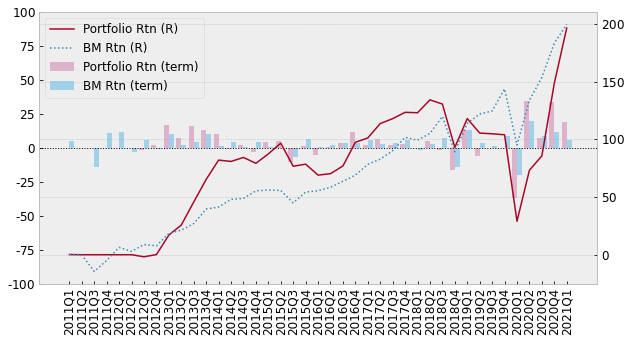

In [ ]:
# High F-Score
s1, s2, s3, s, signal = {}, {}, {}, {}, {}
for t in terms:
  s1[t] = fs.fn_filter(data[t], by='Market Cap', floor=0, n=1000, asc=True) # 시총0~1000 인 소형주 기업
  s2[t] = fs.fn_filter(data[t], by='PBR', floor=.1, cap=1, asc=True)
  s3[t] = fs.fn_filter(data[t], by='F_Score', floor=7, cap=9, asc=False)
  s[t] = fs.combine_signal(s1[t], s2[t], s3[t]).sample(frac=1)[:30] # 선택된 종목으로 합성후 랜덤으로 30개 주 추첨
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)
fs.draw_return(df)

In [ ]:
# Dataframe sample 함수의 용법
import pandas as pd

data = {
    'Name' : ['Microsoft Corporation', 'Google, LLC', 'Tesla, lnc', \
              'Apple lnc', 'Netflix, lnc'],
    'Symbol' : ['MSFT', 'GOOG', 'TSLA', 'AAPL', 'NFLX'],
    'Shares' : [100, 50, 150, 200, 80]
}

df = pd.DataFrame(data)
df

,Name,Symbol,Shares
0,Microsoft Corporation,MSFT,100
1,"Google, LLC",GOOG,50
2,"Tesla, lnc",TSLA,150
3,Apple lnc,AAPL,200
4,"Netflix, lnc",NFLX,80


In [ ]:
df_sub = df.sample(frac=.67) # 전체중 67% 랜덤하게 추첨
print(df_sub)

           Name Symbol  Shares
2    Tesla, lnc   TSLA     150
3     Apple lnc   AAPL     200
4  Netflix, lnc   NFLX      80


Joseph Piotroski F score
- 그때 그때 선택되는 30개 종목이 다름
- 1,000회 반복하여 평균을 낸다고 함

CAGR: 26.23%
Accumulated return: 928.99%
Investment period: 10.0yrs
Sharpe ratio: 3.35
MDD: -23.60%


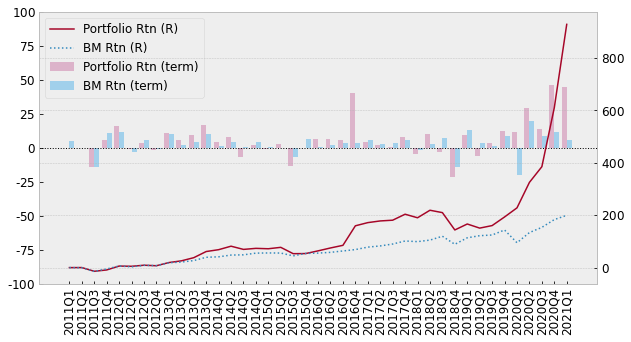

In [ ]:
# Mid F-Score
s1, s2, s3, s, signal = {}, {}, {}, {}, {}
for t in terms:
  s1[t] = fs.fn_filter(data[t], by='Market Cap', floor=0, n=1000, asc=True) # 시총0~1000 인 소형주 기업
  s2[t] = fs.fn_filter(data[t], by='PBR', floor=.1, cap=1, asc=True)
  s3[t] = fs.fn_filter(data[t], by='F_Score', floor=4, cap=6, asc=False)
  s[t] = fs.combine_signal(s1[t], s2[t], s3[t]).sample(frac=1)[:30] # 선택된 종목으로 합성후 랜덤으로 30개 주 추첨
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)
fs.draw_return(df)

CAGR: 27.26%
Accumulated return: 1016.12%
Investment period: 10.0yrs
Sharpe ratio: 2.70
MDD: -32.22%


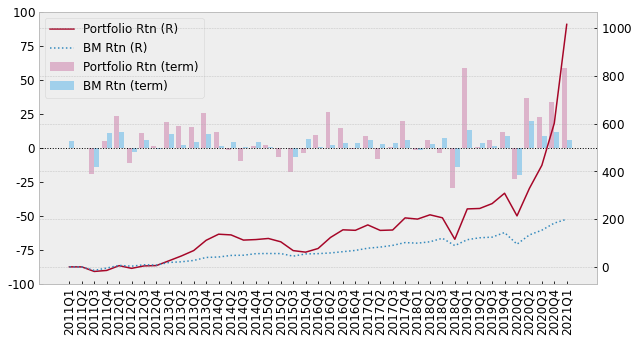

In [ ]:
# Low F-Score
s1, s2, s3, s, signal = {}, {}, {}, {}, {}
for t in terms:
  s1[t] = fs.fn_filter(data[t], by='Market Cap', floor=0, n=1000, asc=True) # 시총0~1000 인 소형주 기업
  s2[t] = fs.fn_filter(data[t], by='PBR', floor=.1, cap=1, asc=True)
  s3[t] = fs.fn_filter(data[t], by='F_Score', floor=0, cap=3, asc=False)
  s[t] = fs.combine_signal(s1[t], s2[t], s3[t]).sample(frac=1)[:30] # 선택된 종목으로 합성후 랜덤으로 30개 주 추첨
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)
fs.draw_return(df)

### 3. 전략 실행을 위한 필수 조건, 유동성
- 유동성이 부족하여 사고팔기 어려운 종목은 매매하지 않도록 하자

In [ ]:
# 유동성 고려 X
data = fs.fn_consolidated(otp='16487125231099712210', term='2020Q4', vol=0)
data['avg_volume']

2020Q4...OK


symbol
A        1583030
AA       4514200
AAIC      195900
AAL     54210000
AAMC        6700
          ...   
ZUMZ      332933
ZUO      1440630
ZVO       527933
ZYME      321367
ZYXI      750633
Name: avg_volume, Length: 4125, dtype: int64

In [ ]:
# 유동성 고려(100만주 이상)
data = fs.fn_consolidated(otp='16487125231099712210', term='2020Q4', vol=1000000)
data['avg_volume']

2020Q4...OK


symbol
A         1583030
AA        4514200
AAL      54210000
AAPL    186217000
ABB       1482000
          ...    
ZS        3182870
ZSAN      4593800
ZTO       3821430
ZTS       1792600
ZUO       1440630
Name: avg_volume, Length: 1252, dtype: int64

In [ ]:
# 유동성 백테스팅
# 10만 volume(중유동주)
terms = fs.set_terms(trade_start='2011Q1', trade_end='2021Q1')
data = {}
for t in terms:
  data[t] = fs.fn_consolidated(otp='16487125231099712210', term=t, vol=100000)

2010Q4...OK
2011Q1...OK
2011Q2...OK
2011Q3...OK
2011Q4...OK
2012Q1...OK
2012Q2...OK
2012Q3...OK
2012Q4...OK
2013Q1...OK
2013Q2...OK
2013Q3...OK
2013Q4...OK
2014Q1...OK
2014Q2...OK
2014Q3...OK
2014Q4...OK
2015Q1...OK
2015Q2...OK
2015Q3...OK
2015Q4...OK
2016Q1...OK
2016Q2...OK
2016Q3...OK
2016Q4...OK
2017Q1...OK
2017Q2...OK
2017Q3...OK
2017Q4...OK
2018Q1...OK
2018Q2...OK
2018Q3...OK
2018Q4...OK
2019Q1...OK
2019Q2...OK
2019Q3...OK
2019Q4...OK
2020Q1...OK
2020Q2...OK
2020Q3...OK
2020Q4...OK


In [ ]:
for t in terms:
  # Set previous terms
  prev_t = fs.quarters_before(terms, t, 4)
  # Company Size
  data[t]['Market Cap'] = data[t]['Price_M3'] * data[t]['Shares']

  #Value
  data[t]['PER'] = data[t]['Price_M3'] / data[t]['EPS'] # 주가수익비율
  data[t]['PBR'] = data[t]['Price_M3'] / (data[t]['Shareholders Equity'] / data[t]['Shares']) # 주가순자산비율
  data[t]['PSR'] = data[t]['Price_M3'] / (data[t]['Revenue'] / data[t]['Shares']) # 주가매출비율
  data[t]['PCR'] = data[t]['Price_M3'] / ((data[t]['Net Income'] + data[t]['Depreciation']) / data[t]['Shares']) # 주가현금흐름비율

  # Profitability
  data[t]['Avg Assets'] = (data[t]['Total Assets'] + data[prev_t]['Total Assets']) / 2 # 평균 자산
  data[t]['Avg Equity'] = (data[t]['Shareholders Equity'] + data[prev_t]['Shareholders Equity']) / 2 # 평균 자본
  data[t]['ROA'] = data[t]['Net Income'] / data[t]['Avg Assets'] # 자산대비이익
  data[t].loc[(data[t]['Net Income'] < 0) | (data[t]['Avg Assets'] < 0) | (data[t]['Total Assets'] < 0), 'ROA'] = float('nan')
  data[t]['ROE'] = data[t]['Net Income'] / data[t]['Avg Equity'] # 자본대비이익
  data[t].loc[(data[t]['Net Income'] < 0) | (data[t]['Avg Equity'] < 0) | (data[t]['Shareholders Equity'] < 0), 'ROE'] = float('nan')
  data[t]['GP/A'] = data[t]['Gross Profit'] / data[t]['Avg Assets'] # 자산대비 영업효율
  data[t].loc[(data[t]['Gross Profit'] < 0) | (data[t]['Avg Assets'] < 0) | (data[t]['Total Assets'] < 0), 'GP/A'] = float('nan')
  data[t]['GP/E'] = data[t]['Gross Profit'] / data[t]['Avg Equity'] # 자본대비 영업효율

  # Stability
  data[t]['Liability/Equity'] = data[t]['Total Liabilities'] / data[t]['Shareholders Equity'] # 부채비율
  data[t].loc[(data[t]['Shareholders Equity'] < 0), 'Liability/Equity'] = float('nan')
  data[t]['Debt/Equity'] = (data[t]['Long Term Debt'] + data[t]['Current Debt']) / data[t]['Shareholders Equity'] # 차입금비율
  data[t].loc[(data[t]['Shareholders Equity'] < 0), 'Debt/Equity'] = float('nan')
  data[t]['Current Ratio'] = data[t]['Current Assets'] / data[t]['Current Liabilities'] # 현재 부채 대비 자산
  data[t]['Shares Increase'] = data[t]['Shares'] / data[prev_t]['Shares'] # 주식수 증가율

  # Efficiency
  data[t]['Gross Margin'] = data[t]['Gross Profit'] / data[t]['Revenue'] # 매출 총이익률
  data[t]['Asset Turnover'] = data[t]['Revenue'] / data[t]['Avg Assets'] # 총자산 회전율
  data[t]['Equity Turnover'] = data[t]['Revenue'] / data[t]['Avg Equity'] # 총자본 회전율

  # Momentum
  data[t]['Price Growth'] = data[t]['Price_M3'] / data[prev_t]['Price_M3'] # 주가 성장률

In [ ]:
# GP/E + 소형주 + 증자X + 중유동주
s1, s2, s3, s, signal = {}, {}, {}, {}, {}
for t in terms:
  s1[t] = fs.fn_score(data[t], by='GP/E', method='relative', floor=0, asc=False)
  s2[t] = fs.fn_filter(data[t], by='Market Cap', floor=0, n=1000, asc=True)
  s3[t] = fs.fn_filter(data[t], by='Shares Increase', floor=.9, cap=1)
  s[t] = fs.combine_signal(s1[t], s2[t], s3[t], how='and', n=30)
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)

CAGR: 12.85%
Accumulated return: 235.18%
Investment period: 10.0yrs
Sharpe ratio: 0.79
MDD: -56.79%


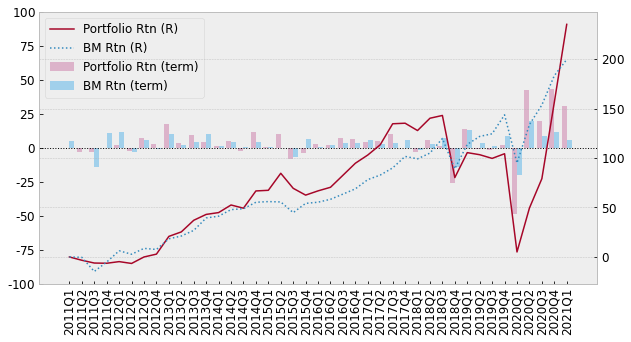

In [ ]:
fs.draw_return(df)

In [ ]:
# 유동성 백테스팅
# 100만 volume(고유동주)
terms = fs.set_terms(trade_start='2011Q1', trade_end='2021Q1')
data = {}
for t in terms:
  data[t] = fs.fn_consolidated(otp='16487125231099712210', term=t, vol=1000000)

2010Q4...OK
2011Q1...OK
2011Q2...OK
2011Q3...OK
2011Q4...OK
2012Q1...OK
2012Q2...OK
2012Q3...OK
2012Q4...OK
2013Q1...OK
2013Q2...OK
2013Q3...OK
2013Q4...OK
2014Q1...OK
2014Q2...OK
2014Q3...OK
2014Q4...OK
2015Q1...OK
2015Q2...OK
2015Q3...OK
2015Q4...OK
2016Q1...OK
2016Q2...OK
2016Q3...OK
2016Q4...OK
2017Q1...OK
2017Q2...OK
2017Q3...OK
2017Q4...OK
2018Q1...OK
2018Q2...OK
2018Q3...OK
2018Q4...OK
2019Q1...OK
2019Q2...OK
2019Q3...OK
2019Q4...OK
2020Q1...OK
2020Q2...OK
2020Q3...OK
2020Q4...OK


In [ ]:
for t in terms:
  # Set previous terms
  prev_t = fs.quarters_before(terms, t, 4)
  # Company Size
  data[t]['Market Cap'] = data[t]['Price_M3'] * data[t]['Shares']

  #Value
  data[t]['PER'] = data[t]['Price_M3'] / data[t]['EPS'] # 주가수익비율
  data[t]['PBR'] = data[t]['Price_M3'] / (data[t]['Shareholders Equity'] / data[t]['Shares']) # 주가순자산비율
  data[t]['PSR'] = data[t]['Price_M3'] / (data[t]['Revenue'] / data[t]['Shares']) # 주가매출비율
  data[t]['PCR'] = data[t]['Price_M3'] / ((data[t]['Net Income'] + data[t]['Depreciation']) / data[t]['Shares']) # 주가현금흐름비율

  # Profitability
  data[t]['Avg Assets'] = (data[t]['Total Assets'] + data[prev_t]['Total Assets']) / 2 # 평균 자산
  data[t]['Avg Equity'] = (data[t]['Shareholders Equity'] + data[prev_t]['Shareholders Equity']) / 2 # 평균 자본
  data[t]['ROA'] = data[t]['Net Income'] / data[t]['Avg Assets'] # 자산대비이익
  data[t].loc[(data[t]['Net Income'] < 0) | (data[t]['Avg Assets'] < 0) | (data[t]['Total Assets'] < 0), 'ROA'] = float('nan')
  data[t]['ROE'] = data[t]['Net Income'] / data[t]['Avg Equity'] # 자본대비이익
  data[t].loc[(data[t]['Net Income'] < 0) | (data[t]['Avg Equity'] < 0) | (data[t]['Shareholders Equity'] < 0), 'ROE'] = float('nan')
  data[t]['GP/A'] = data[t]['Gross Profit'] / data[t]['Avg Assets'] # 자산대비 영업효율
  data[t].loc[(data[t]['Gross Profit'] < 0) | (data[t]['Avg Assets'] < 0) | (data[t]['Total Assets'] < 0), 'GP/A'] = float('nan')
  data[t]['GP/E'] = data[t]['Gross Profit'] / data[t]['Avg Equity'] # 자본대비 영업효율

  # Stability
  data[t]['Liability/Equity'] = data[t]['Total Liabilities'] / data[t]['Shareholders Equity'] # 부채비율
  data[t].loc[(data[t]['Shareholders Equity'] < 0), 'Liability/Equity'] = float('nan')
  data[t]['Debt/Equity'] = (data[t]['Long Term Debt'] + data[t]['Current Debt']) / data[t]['Shareholders Equity'] # 차입금비율
  data[t].loc[(data[t]['Shareholders Equity'] < 0), 'Debt/Equity'] = float('nan')
  data[t]['Current Ratio'] = data[t]['Current Assets'] / data[t]['Current Liabilities'] # 현재 부채 대비 자산
  data[t]['Shares Increase'] = data[t]['Shares'] / data[prev_t]['Shares'] # 주식수 증가율

  # Efficiency
  data[t]['Gross Margin'] = data[t]['Gross Profit'] / data[t]['Revenue'] # 매출 총이익률
  data[t]['Asset Turnover'] = data[t]['Revenue'] / data[t]['Avg Assets'] # 총자산 회전율
  data[t]['Equity Turnover'] = data[t]['Revenue'] / data[t]['Avg Equity'] # 총자본 회전율

  # Momentum
  data[t]['Price Growth'] = data[t]['Price_M3'] / data[prev_t]['Price_M3'] # 주가 성장률

CAGR: 13.15%
Accumulated return: 244.41%
Investment period: 10.0yrs
Sharpe ratio: 1.39
MDD: -27.78%


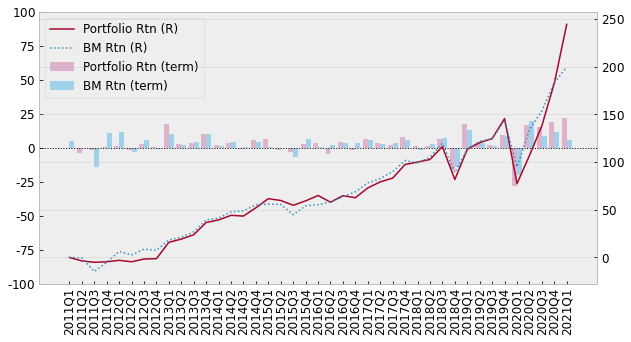

In [ ]:
# GP/E + 소형주 + 증자X + 중유동주
s1, s2, s3, s, signal = {}, {}, {}, {}, {}
for t in terms:
  s1[t] = fs.fn_score(data[t], by='GP/E', method='relative', floor=0, asc=False)
  s2[t] = fs.fn_filter(data[t], by='Market Cap', floor=0, n=1000, asc=True)
  s3[t] = fs.fn_filter(data[t], by='Shares Increase', floor=.9, cap=1)
  s[t] = fs.combine_signal(s1[t], s2[t], s3[t], how='and', n=30)
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)
fs.draw_return(df)

### 4. 세상에 없는 나만의 투자 전략 만들기
1. 가치투자 4대장 콤보 + 소형주
2. (4대장 + GP/A + 부채비율+유동비율) + 소형주 + 증자X
3. (4대장 GP/E + 부채비율 + 유동비율) + 소형주 + 증자X +모멘텀
4. GP/A + 소형주 + 증자X
5. 자산회전율 + GP/A + 소형주

In [ ]:
# 재무데이터 세팅
terms = fs.set_terms(trade_start='2011Q1', trade_end='2021Q1')
data = {}
for t in terms:
  data[t] = fs.fn_consolidated(otp='16491726171099712210', term=t)

2010Q4...OK
2011Q1...OK
2011Q2...OK
2011Q3...OK
2011Q4...OK
2012Q1...OK
2012Q2...OK
2012Q3...OK
2012Q4...OK
2013Q1...OK
2013Q2...OK
2013Q3...OK
2013Q4...OK
2014Q1...OK
2014Q2...OK
2014Q3...OK
2014Q4...OK
2015Q1...OK
2015Q2...OK
2015Q3...OK
2015Q4...OK
2016Q1...OK
2016Q2...OK
2016Q3...OK
2016Q4...OK
2017Q1...OK
2017Q2...OK
2017Q3...OK
2017Q4...OK
2018Q1...OK
2018Q2...OK
2018Q3...OK
2018Q4...OK
2019Q1...OK
2019Q2...OK
2019Q3...OK
2019Q4...OK
2020Q1...OK
2020Q2...OK
2020Q3...OK
2020Q4...OK


In [ ]:
# factor 계산
for t in terms:
  # Set previous terms
  prev_t = fs.quarters_before(terms, t, 4)
  # Company Size
  data[t]['Market Cap'] = data[t]['Price_M3'] * data[t]['Shares']

  #Value
  data[t]['PER'] = data[t]['Price_M3'] / data[t]['EPS'] # 주가수익비율
  data[t]['PBR'] = data[t]['Price_M3'] / (data[t]['Shareholders Equity'] / data[t]['Shares']) # 주가순자산비율
  data[t]['PSR'] = data[t]['Price_M3'] / (data[t]['Revenue'] / data[t]['Shares']) # 주가매출비율
  data[t]['PCR'] = data[t]['Price_M3'] / ((data[t]['Net Income'] + data[t]['Depreciation']) / data[t]['Shares']) # 주가현금흐름비율

  # Profitability
  data[t]['Avg Assets'] = (data[t]['Total Assets'] + data[prev_t]['Total Assets']) / 2 # 평균 자산
  data[t]['Avg Equity'] = (data[t]['Shareholders Equity'] + data[prev_t]['Shareholders Equity']) / 2 # 평균 자본
  data[t]['ROA'] = data[t]['Net Income'] / data[t]['Avg Assets'] # 자산대비이익
  data[t].loc[(data[t]['Net Income'] < 0) | (data[t]['Avg Assets'] < 0) | (data[t]['Total Assets'] < 0), 'ROA'] = float('nan')
  data[t]['ROE'] = data[t]['Net Income'] / data[t]['Avg Equity'] # 자본대비이익
  data[t].loc[(data[t]['Net Income'] < 0) | (data[t]['Avg Equity'] < 0) | (data[t]['Shareholders Equity'] < 0), 'ROE'] = float('nan')
  data[t]['GP/A'] = data[t]['Gross Profit'] / data[t]['Avg Assets'] # 자산대비 영업효율
  data[t].loc[(data[t]['Gross Profit'] < 0) | (data[t]['Avg Assets'] < 0) | (data[t]['Total Assets'] < 0), 'GP/A'] = float('nan')
  data[t]['GP/E'] = data[t]['Gross Profit'] / data[t]['Avg Equity'] # 자본대비 영업효율

  # Stability
  data[t]['Liability/Equity'] = data[t]['Total Liabilities'] / data[t]['Shareholders Equity'] # 부채비율
  data[t].loc[(data[t]['Shareholders Equity'] < 0), 'Liability/Equity'] = float('nan')
  data[t]['Debt/Equity'] = (data[t]['Long Term Debt'] + data[t]['Current Debt']) / data[t]['Shareholders Equity'] # 차입금비율
  data[t].loc[(data[t]['Shareholders Equity'] < 0), 'Debt/Equity'] = float('nan')
  data[t]['Current Ratio'] = data[t]['Current Assets'] / data[t]['Current Liabilities'] # 현재 부채 대비 자산
  data[t]['Shares Increase'] = data[t]['Shares'] / data[prev_t]['Shares'] # 주식수 증가율

  # Efficiency
  data[t]['Gross Margin'] = data[t]['Gross Profit'] / data[t]['Revenue'] # 매출 총이익률
  data[t]['Asset Turnover'] = data[t]['Revenue'] / data[t]['Avg Assets'] # 총자산 회전율
  data[t]['Equity Turnover'] = data[t]['Revenue'] / data[t]['Avg Equity'] # 총자본 회전율

  # Momentum
  data[t]['Price Growth'] = data[t]['Price_M3'] / data[prev_t]['Price_M3'] # 주가 성장률

CAGR: 11.43%
Accumulated return: 195.51%
Investment period: 10.0yrs
Sharpe ratio: 0.63
MDD: -48.92%


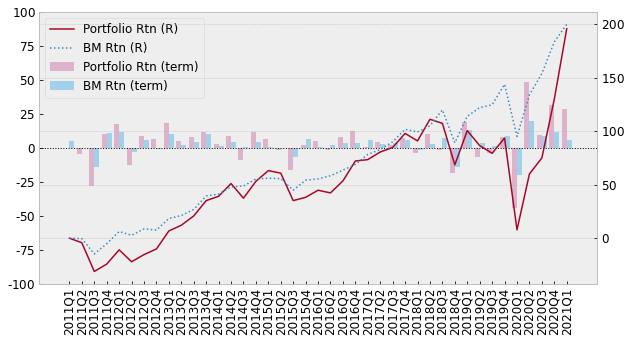

In [ ]:
# 가치투자 4대장 콤보 + 소형주
s1, s2, s3, s4, s5, s6, s, signal = {}, {}, {}, {}, {}, {}, {}, {}
for t in terms:
  s1[t] = fs.fn_score(data[t], by='PER', method='relative', floor=1, asc=True)
  s2[t] = fs.fn_score(data[t], by='PBR', method='relative', floor=.1, asc=True)
  s3[t] = fs.fn_score(data[t], by='PSR', method='relative', floor=.1, asc=True)
  s4[t] = fs.fn_score(data[t], by='PCR', method='relative', floor=.1, asc=True)
  s5[t] = fs.fn_filter(data[t], by='Market Cap', floor=0, n=1000, asc=True)
  s6[t] = fs.combine_score(s1[t], s2[t], s3[t], s4[t])
  s[t] = fs.combine_signal(s6[t], s5[t], how='and', n=50)
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)
fs.draw_return(df)

CAGR: 9.45%
Accumulated return: 146.76%
Investment period: 10.0yrs
Sharpe ratio: 0.53
MDD: -52.28%


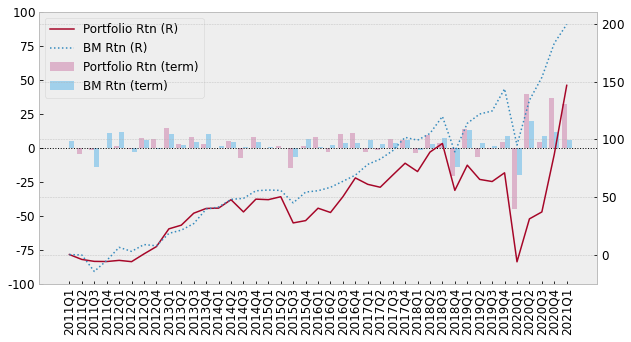

In [ ]:
# (4대장 + GP/A + 부채비율 + 유동비율) + 소형주 + 증자X
s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11, s, signal = {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}
for t in terms:
  s1[t] = fs.fn_score(data[t], by='PER', method='relative', floor=1, asc=True)
  s2[t] = fs.fn_score(data[t], by='PBR', method='relative', floor=.1, asc=True)
  s3[t] = fs.fn_score(data[t], by='PSR', method='relative', floor=.1, asc=True)
  s4[t] = fs.fn_score(data[t], by='PCR', method='relative', floor=.1, asc=True)
  s5[t] = fs.fn_score(data[t], by='ROE', method='relative', floor=.1, asc=False)
  s6[t] = fs.fn_score(data[t], by='GP/A', method='relative', floor=0, asc=False)
  s7[t] = fs.fn_score(data[t], by='Debt/Equity', method='relative', floor=0, asc=True)
  s8[t] = fs.fn_score(data[t], by='Current Ratio', method='relative', floor=0, asc=False)

  s9[t] = fs.fn_filter(data[t], by='Market Cap', floor=0, n=1000, asc=True)
  s10[t] = fs.fn_filter(data[t], by='Shares Increase', floor=.9, cap=1)

  s11[t] = fs.combine_score(s1[t], s2[t], s3[t], s4[t], s5[t], s6[t], s7[t], s8[t])
  s[t] = fs.combine_signal(s11[t], s9[t], s10[t], how='and', n=50)
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)
fs.draw_return(df)

CAGR: 6.19%
Accumulated return: 82.48%
Investment period: 10.0yrs
Sharpe ratio: 0.46
MDD: -39.96%


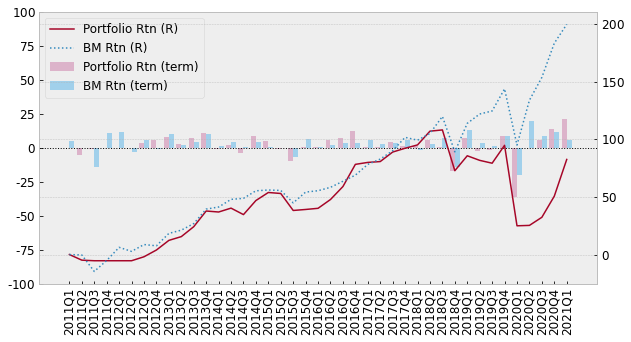

In [ ]:
# (4대장 + GP/A + 부채비율 + 유동비율) + 소형주 + 증자X + 모멘텀
s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11, s12, s, signal = {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}
for t in terms:
  s1[t] = fs.fn_score(data[t], by='PER', method='relative', floor=1, asc=True)
  s2[t] = fs.fn_score(data[t], by='PBR', method='relative', floor=.1, asc=True)
  s3[t] = fs.fn_score(data[t], by='PSR', method='relative', floor=.1, asc=True)
  s4[t] = fs.fn_score(data[t], by='PCR', method='relative', floor=.1, asc=True)
  s5[t] = fs.fn_score(data[t], by='ROE', method='relative', floor=.1, asc=False)
  s6[t] = fs.fn_score(data[t], by='GP/A', method='relative', floor=0, asc=False)
  s7[t] = fs.fn_score(data[t], by='Debt/Equity', method='relative', floor=0, asc=True)
  s8[t] = fs.fn_score(data[t], by='Current Ratio', method='relative', floor=0, asc=False)

  s9[t] = fs.fn_filter(data[t], by='Market Cap', floor=0, n=1000, asc=True)
  s10[t] = fs.fn_filter(data[t], by='Shares Increase', floor=.9, cap=1)
  s11[t] = fs.fn_filter(data[t], by='Price Growth', floor=1)

  s12[t] = fs.combine_score(s1[t], s2[t], s3[t], s4[t], s5[t], s6[t], s7[t], s8[t])
  s[t] = fs.combine_signal(s11[t], s9[t], s10[t], s11[t], how='and', n=50)
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)
fs.draw_return(df)

CAGR: 10.07%
Accumulated return: 161.12%
Investment period: 10.0yrs
Sharpe ratio: 0.62
MDD: -49.04%


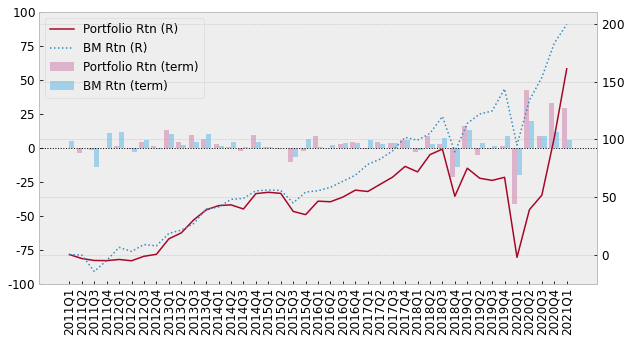

In [ ]:
# GP/A + 소형주 + 증자X
s1, s2, s3, s, signal = {}, {}, {}, {}, {}
for t in terms:
  s1[t] = fs.fn_score(data[t], by='GP/A', method='relative', floor=0, asc=False)

  s2[t] = fs.fn_filter(data[t], by='Market Cap', floor=0, n=1000, asc=True)
  s3[t] = fs.fn_filter(data[t], by='Shares Increase', floor=0.9, cap=1)
  s[t] = fs.combine_signal(s1[t], s2[t], s3[t], how='and', n=50)
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)
fs.draw_return(df)

CAGR: 16.40%
Accumulated return: 357.00%
Investment period: 10.0yrs
Sharpe ratio: 1.20
MDD: -38.02%


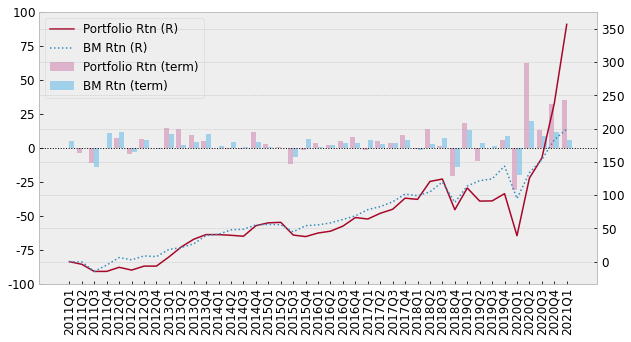

In [ ]:
# 자산회전율 + GP/A + 소형주
s1, s2, s3, s4, s, signal = {}, {}, {}, {}, {}, {}
for t in terms:
  s1[t] = fs.fn_score(data[t], by='Asset Turnover', method='relative', floor=0, asc=False)
  s2[t] = fs.fn_score(data[t], by='GP/A', method='relative', floor=0, asc=False)

  s3[t] = fs.fn_filter(data[t], by='Market Cap', floor=0, n=1000, asc=True)
  s4[t] = fs.combine_score(s1[t], s2[t])

  s[t] = fs.combine_signal(s4[t], s3[t], how='and', n=50)
  signal[t] = list(s[t].index)

df = fs.backtest(signal=signal, data=data, m=3, cost=.001)
fs.draw_return(df)